<a href="https://colab.research.google.com/github/nsk6704/TheDormancyProblem/blob/main/DormancyAnalysis(v2).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dormancy Analysis

In [ ]:
!pip install scikit-learn pandas numpy

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
df = pd.read_csv("dormat.csv")

df['createdAt'] = pd.to_datetime(df['createdAt'])
df = df.sort_values(["userId", "createdAt"])

In [ ]:
df["interval"] = (
    df.groupby("userId")["createdAt"].diff().dt.total_seconds() / 86400
)

last = df.groupby("userId")["createdAt"].max().reset_index()
current_time = df["createdAt"].max() + pd.Timedelta(days=1)
last["recency"] = (
    (current_time - last["createdAt"]).dt.total_seconds() / 86400
)

stats = df.groupby("userId")["interval"].agg(["mean", "std"]).reset_index()
stats.columns = ["userId", "avg_interval", "std_interval"]

features = stats.merge(last[["userId", "recency"]], on="userId")
features = features.fillna(0)

In [ ]:
X = features[["avg_interval", "std_interval", "recency"]]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [ ]:
kmeans = KMeans(n_clusters=4, random_state=42)
features["kmeans_cluster"] = kmeans.fit_predict(X_scaled)

In [ ]:
gmm = GaussianMixture(n_components=4, random_state=42)
features["gmm_cluster"] = gmm.fit_predict(X_scaled)

In [ ]:
print("\n=== K-MEANS CLUSTER SUMMARY ===")
summary_km = features.groupby("kmeans_cluster")[["avg_interval", "std_interval", "recency"]].mean()
print(summary_km)


=== K-MEANS CLUSTER SUMMARY ===
                avg_interval  std_interval     recency
kmeans_cluster                                        
0                   0.930977      0.810941  266.852053
1                   0.415605      0.978055   81.983537
2                   7.927838     23.050083  102.502647
3                  26.995455      0.000000  259.245891


In [ ]:
print("\n=== GMM CLUSTER SUMMARY ===")
summary_gmm = features.groupby("gmm_cluster")[["avg_interval", "std_interval", "recency"]].mean()
print(summary_gmm)


=== GMM CLUSTER SUMMARY ===
             avg_interval  std_interval     recency
gmm_cluster                                        
0                0.000710      0.000371  277.834069
1                0.431020      0.000355  147.138820
2                2.244274      3.510663  235.274854
3               26.995455      0.000000  259.245891


In [ ]:
km_sorted = summary_km.sort_values("recency")

km_cluster_map = {
    km_sorted.index[0]: "Highly Active",
    km_sorted.index[1]: "Moderately Active",
    km_sorted.index[2]: "At Risk",
    km_sorted.index[3]: "Dormant"
}

features["kmeans_label"] = features["kmeans_cluster"].map(km_cluster_map)

print("\n=== K-MEANS LABELS ===")
print(features[["userId", "kmeans_cluster", "kmeans_label"]].head(20))


=== K-MEANS LABELS ===
    userId  kmeans_cluster       kmeans_label
0      112               1      Highly Active
1      116               1      Highly Active
2      126               1      Highly Active
3      148               2  Moderately Active
4      621               2  Moderately Active
5      641               2  Moderately Active
6      642               1      Highly Active
7      643               2  Moderately Active
8      672               1      Highly Active
9      809               0            Dormant
10     901               0            Dormant
11     963               0            Dormant
12    1025               2  Moderately Active
13    1107               0            Dormant
14    1789               1      Highly Active
15    1872               0            Dormant
16    1878               2  Moderately Active
17    2357               1      Highly Active
18    2570               0            Dormant
19    3195               2  Moderately Active


In [ ]:
gmm_sorted = summary_gmm.sort_values("recency")

gmm_cluster_map = {
    gmm_sorted.index[0]: "Highly Active",
    gmm_sorted.index[1]: "Moderately Active",
    gmm_sorted.index[2]: "At Risk",
    gmm_sorted.index[3]: "Dormant"
}

features["gmm_label"] = features["gmm_cluster"].map(gmm_cluster_map)

print("\n=== GMM LABELS ===")
print(features[["userId", "gmm_cluster", "gmm_label"]].head(20))


=== GMM LABELS ===
    userId  gmm_cluster          gmm_label
0      112            1      Highly Active
1      116            1      Highly Active
2      126            1      Highly Active
3      148            2  Moderately Active
4      621            2  Moderately Active
5      641            2  Moderately Active
6      642            2  Moderately Active
7      643            2  Moderately Active
8      672            2  Moderately Active
9      809            2  Moderately Active
10     901            0            Dormant
11     963            0            Dormant
12    1025            2  Moderately Active
13    1107            0            Dormant
14    1789            2  Moderately Active
15    1872            0            Dormant
16    1878            2  Moderately Active
17    2357            2  Moderately Active
18    2570            2  Moderately Active
19    3195            2  Moderately Active


In [ ]:
# cluster summary (mean recency per cluster)
summary_km = features.groupby("kmeans_cluster")["recency"].mean()

# sort clusters by recency ascending → most active first
sorted_km = summary_km.sort_values()

km_cluster_map = {
    sorted_km.index[0]: "Highly Active",
    sorted_km.index[1]: "Moderately Active",
    sorted_km.index[2]: "At Risk",
    sorted_km.index[3]: "Dormant"
}

# apply labels
features["kmeans_label"] = features["kmeans_cluster"].map(km_cluster_map)

print("=== KMEANS CLUSTER LABELS ===")
print(km_cluster_map)

=== KMEANS CLUSTER LABELS ===
{np.int32(1): 'Highly Active', np.int32(2): 'Moderately Active', np.int32(3): 'At Risk', np.int32(0): 'Dormant'}


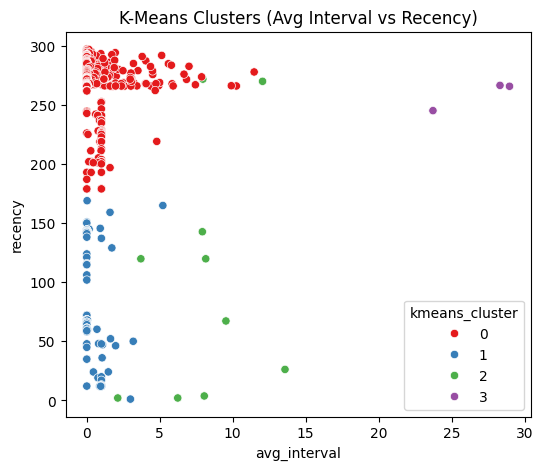

In [ ]:
plt.figure(figsize=(6,5))
sns.scatterplot(
    x=features["avg_interval"],
    y=features["recency"],
    hue=features["kmeans_cluster"],
    palette="Set1"
)
plt.title("K-Means Clusters (Avg Interval vs Recency)")
plt.show()

In [ ]:
print("\n=== K-MEANS USERS PER LABEL ===")
print(features["kmeans_label"].value_counts())


=== K-MEANS USERS PER LABEL ===
kmeans_label
Dormant              344
Highly Active         93
Moderately Active     10
At Risk                3
Name: count, dtype: int64


In [ ]:
summary_gmm = features.groupby("gmm_cluster")["recency"].mean()

sorted_gmm = summary_gmm.sort_values()

gmm_cluster_map = {
    sorted_gmm.index[0]: "Highly Active",
    sorted_gmm.index[1]: "Moderately Active",
    sorted_gmm.index[2]: "At Risk",
    sorted_gmm.index[3]: "Dormant"
}

features["gmm_label"] = features["gmm_cluster"].map(gmm_cluster_map)

print("=== GMM CLUSTER LABELS ===")
print(gmm_cluster_map)

=== GMM CLUSTER LABELS ===
{np.int64(1): 'Highly Active', np.int64(2): 'Moderately Active', np.int64(3): 'At Risk', np.int64(0): 'Dormant'}


In [ ]:
print("\n=== GMM USERS PER LABEL ===")
print(features["gmm_label"].value_counts())


=== GMM USERS PER LABEL ===
gmm_label
Moderately Active    171
Dormant              150
Highly Active        126
At Risk                3
Name: count, dtype: int64


In [ ]:
with open("gmm_model.pkl", "wb") as f:
    pickle.dump(gmm, f)

In [ ]:
with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)